# Branch and Bound

Algorytm branch and bound polega na systematycznym przeszukiwaniu przestrzeni rozwiązań problemu optymalizacji kombinatorycznej przy jednoczesnym ograniczaniu liczby badanych przypadków. W ogólności, składa się z 3 rodzajów operacji: 

* **Rozgałęzianie (branching)**: Problem jest dzielony na mniejsze podproblemy, które odpowiadają różnym podzbiorom przestrzeni rozwiązań.  

* **Wyznaczanie ograniczeń (bounding)**: Dla każdego podproblemu oblicza się ograniczenie (np. dolne lub górne), które informuje o tym, jaką najlepszą wartość funkcji celu można osiągnąć w obrębie danego poddrzewa.  

* **Odrzucanie niekorzystnych gałęzi (pruning)**: Jeśli obliczone ograniczenie dla danego podproblemu nie pozwala na uzyskanie lepszego wyniku niż już znalezione rozwiązanie, cały podproblem jest pomijany, co znacząco zmniejsza przestrzeń poszukiwań.

Tutaj zaprezentujemy prostą heurystyczną wersję tego algorytmu.

1. Inicjalizacja $s = \emptyset$, $M = \{\emptyset\}$
2. For $i \in [1, \ldots, N]$
    1. 


WORK IN PROGRESS

![image](pictures/branch_and_bound.png)

In [2]:
# Implementacja prostego Branch and Bound

import numpy as np
from typing import NamedTuple
from math import inf
from tqdm import tqdm


class State(NamedTuple):
    configuration: list
    energy: float


# Funkcja pomocniczna, warto zauważyć że są prowadzone pewne modyfikacje
def calculate_energy(J: np.ndarray, h: np.ndarray, state: list):
    n = len(h)
    k = len(state)
    state = state + [0] * (n - k)
    state = np.array(state)
    return state @ J @ state.T + state @ h 


def branch_and_bound(J, h, num_states):
    
    n = len(h)
    states = [State([], inf)]
    
    for _ in tqdm(range(n), desc="Wykonywanie branch and bound"):
        # Branching
        temp = []
        for state in states:
            plus = state.configuration + [1]
            plus_energy = calculate_energy(J, h, plus)
            temp.append(State(plus, plus_energy))

            minus = state.configuration + [-1]
            minus_energy = calculate_energy(J, h, minus)
            temp.append(State(minus, minus_energy))
        
        # Bounding
        temp.sort(key=lambda x: x.energy)
        if len(temp) > num_states:
            temp = temp[:num_states]
        states = temp

    return states[0]

        

In [3]:
# test dla bardzo małej instancji

from funkcje_pomocnicze import read_instance, small_pegasus

J, h = read_instance(small_pegasus.path, convention="dwave")



solution = branch_and_bound(J, h, 100)
print(f"Otrzymana energia: {solution.energy}")
print(f"Stan podstawowy: {small_pegasus.best_energy}")

Wykonywanie branch and bound: 100%|██████████| 24/24 [00:00<00:00, 670.23it/s]

Otrzymana energia: -39.0
Stan podstawowy: -39.0


## Testy algorytmu

W następnych komurkach przeprowadzimy testy jak ten algorytm się zachowuje dla różnych rozmiarów instancji oraz różnych wartości

zbieranie danych:   0%|          | 0/9 [00:00<?, ?it/s]

zbieranie danych: 100%|██████████| 9/9 [06:18<00:00, 42.11s/it] 


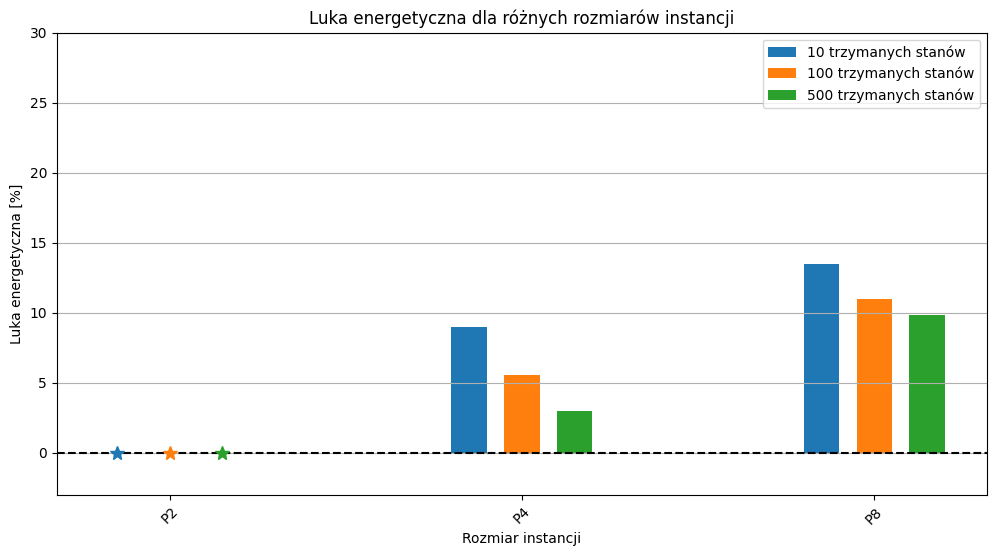

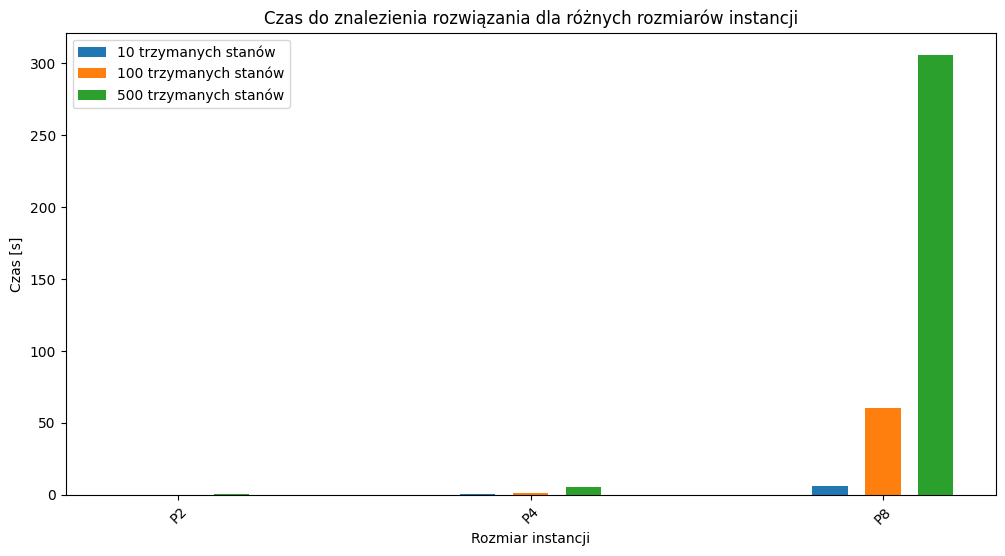

In [25]:
# wykresy zachowania algorytmu

import time
import matplotlib.pyplot as plt
import numpy as np

from funkcje_pomocnicze import P2, P4, P8, read_instance
from IPython.utils.io import capture_output
from tqdm import tqdm

gaps = {}
times = {}

with tqdm(total=9, desc="zbieranie danych") as pbar:
    for instance in [P2, P4, P8]:
        for m in [10, 100, 500]:
            J, h = read_instance(instance.path, convention="dwave")
            with capture_output() as captured:
                start = time.time()
                solution = branch_and_bound(J, h, m)
                end = time.time()
            gap = (instance.best_energy - solution.energy)/instance.best_energy
            gaps[(instance.name, m)] = gap * 100
            times[(instance.name, m)] = end - start
            pbar.update(1)


instancje = ["P2", "P4", "P8"]

x = np.arange(len(instancje))
width = 0.1
offset = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
m_10 = [gaps[(i, 10)] for i in ["P2", "P4", "P8"]]
m_100 = [gaps[(i, 100)] for i in ["P2", "P4", "P8"]]
m_500 = [gaps[(i, 500)] for i in ["P2", "P4", "P8"]]

bar1 = ax.bar(x - offset, m_10, width, label="10 trzymanych stanów")
bar2 = ax.bar(x, m_100, width, label="100 trzymanych stanów")
bar3 = ax.bar(x + offset, m_500, width, label="500 trzymanych stanów")

ax.set_ylim((-3, 30))
ax.set_xlabel("Rozmiar instancji")
ax.set_xticks(x)
ax.set_xticklabels(instancje, rotation=45)
ax.set_ylabel("Luka energetyczna [%]")
ax.set_title("Luka energetyczna dla różnych rozmiarów instancji")
ax.axhline(0, color='black', linestyle='--')

ax.legend()

for bars in [bar1, bar2, bar3]:
    for bar in bars:
        if bar.get_height() == 0:
            center = bar.get_x() + bar.get_width()/2
            ax.plot(center, 0, marker='*', markersize=10, color=bar.get_facecolor())
plt.grid(axis="y")
plt.show()


fig2, ax2 = plt.subplots(figsize=(12, 6))
m_10 = [times[(i, 10)] for i in ["P2", "P4", "P8"]]
m_100 = [times[(i, 100)] for i in ["P2", "P4", "P8"]]
m_500 = [times[(i, 500)] for i in ["P2", "P4", "P8"]]

ax2.bar(x - offset, m_10, width, label="10 trzymanych stanów")
ax2.bar(x, m_100, width, label="100 trzymanych stanów")
ax2.bar(x + offset, m_500, width, label="500 trzymanych stanów")

ax2.set_xlabel("Rozmiar instancji")
ax2.set_xticks(x)
ax2.set_xticklabels(instancje, rotation=45)
ax2.set_ylabel("Czas [s]")
ax2.set_title("Czas do znalezienia rozwiązania dla różnych rozmiarów instancji")
ax2.legend()

plt.show()
